# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 14.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте: https://contest.yandex.ru/contest/6469/run-report/9967126/
* Максимальная оценка: 9.5

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.273682416250637

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.587317275018084

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

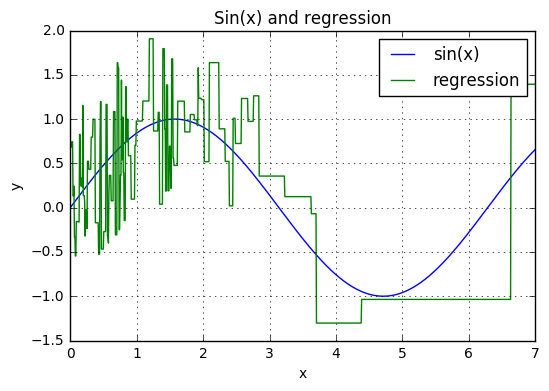

In [13]:
def regress_func(max_depth):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, size=sample_size)
    x1 = x[:, np.newaxis]
    linspace1 = linspace[:, np.newaxis]
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x1, y)
    preds = model.predict(linspace1)
    return preds

linspace = np.linspace(0, 7, 1000)
plt.figure()
plt.plot(linspace, f(linspace), label='sin(x)')
plt.plot(linspace, regress_func(None), label='regression')
plt.title('Sin(x) and regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

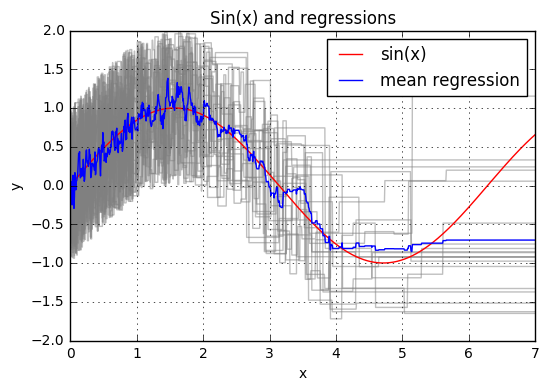

In [14]:
def draw_sin_and_regress(max_depth=None):
    plt.figure()
    preds_arr = []
    for i in range(samples_num):
        preds = regress_func(max_depth)
        preds_arr.append(preds)
        plt.plot(linspace, preds, color='gray', alpha=0.5)

    preds_mean = np.mean(preds_arr, axis=0)
    plt.plot(linspace, f(linspace), color='r', label='sin(x)')
    plt.plot(linspace, preds_mean, color='b', label='mean regression')
    plt.title('Sin(x) and regressions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()
    
draw_sin_and_regress()

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

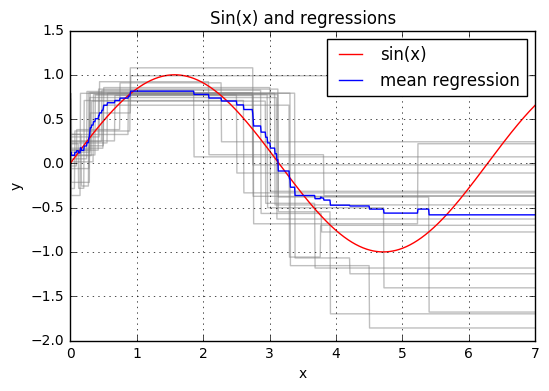

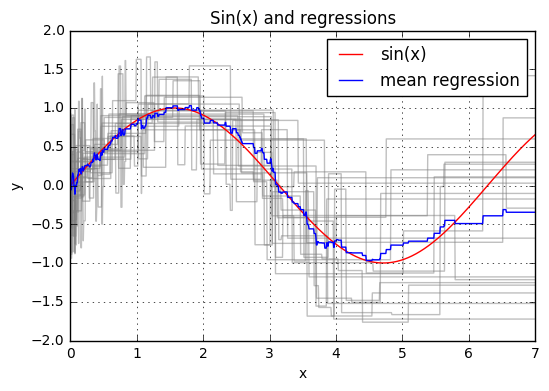

In [15]:
draw_sin_and_regress(max_depth=2)
draw_sin_and_regress(max_depth=4)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**
При восстановлении зависимости с помощью композиции деревьев смещение получается меньше, чем при использовании одного дерева. Наилучший результат получился при max_depth=4. Без ограничения на глубину дерева алгоритмы получаются переобученными, а при max_depth=2 недообученными.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [18]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [19]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [20]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [21]:
from importlib import reload
import hw3code

reload(hw3code)


<module 'hw3code' from '/Users/IrinaStepanyuk/Documents/Documents/hw_master/1y_ML/hw3code.py'>

In [22]:
def g(x):
    return 5*np.sin(10*x)

for i in range(len(regressors)):
    for j in range(len(generators)):
        bias, var = hw3code.compute_bias_variance(regressors[i], g, 
                                                      x_generator=generators[j], noise_generator=generators[j])
        df_bias.iloc[i, j] = bias
        df_variance.iloc[i, j] = var

In [23]:
df_bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1798,7.13028,11.7291,12.0085
DecisionTree,0.0751283,0.0856042,0.00355918,0.000907461
RandomForest,0.0841029,0.128412,0.00388027,0.000933264
GradientBoosting,0.0763127,0.0895467,0.0130303,0.00145208


In [24]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0858639,0.0767993,0.0756079,0.05797
DecisionTree,0.171391,0.229553,0.360477,0.0900397
RandomForest,0.0981851,0.132451,0.196533,0.0488269
GradientBoosting,0.1136,0.162136,0.143824,0.0394338


__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

In [59]:
df_variance.sort_index(ascending=False)

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
RandomForest,0.0981851,0.132451,0.196533,0.0488269
LinearRegression,0.0858639,0.0767993,0.0756079,0.05797
GradientBoosting,0.1136,0.162136,0.143824,0.0394338
DecisionTree,0.171391,0.229553,0.360477,0.0900397


**Ответ:**
Наибольшим разброс на всех выборках у DecisionTree, остальные алгоритмы имеют наименьший разброс на различных выборках. Как известно, деревья обладают большим разбросом и низким смещением (как и видно из таблиц).

Из таблиц видно, что смещение и разброс зависят и от вероятностной модели данных тоже. 

Смещение наибольшее для распределений exponential(0.3) и uniform(-1, 1). 

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [26]:
d = pd.read_csv('students.csv')
d.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


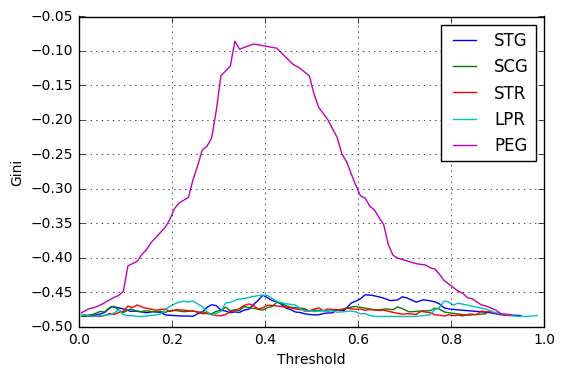

In [27]:
plt.figure()
for i in range(5):
    thresholds, ginis, gini_best, threshold_best = hw3code.find_best_split(d[d.columns[i]], d[d.columns[5]])
    plt.plot(thresholds, ginis, label=str(d.columns[i]))
    plt.grid()
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Gini')

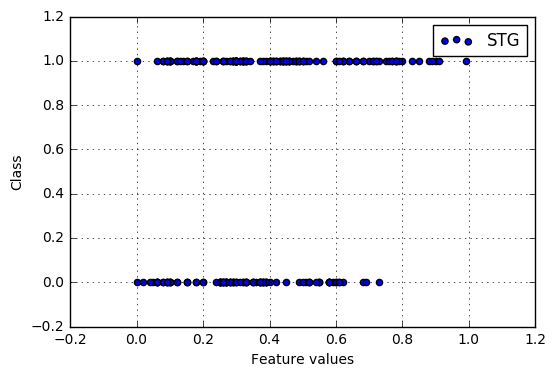

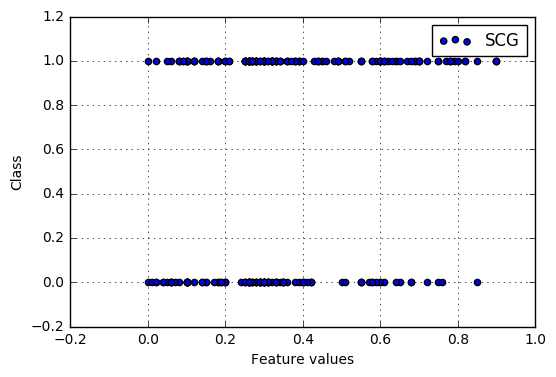

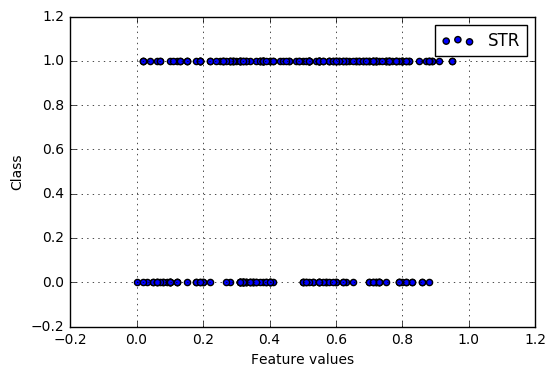

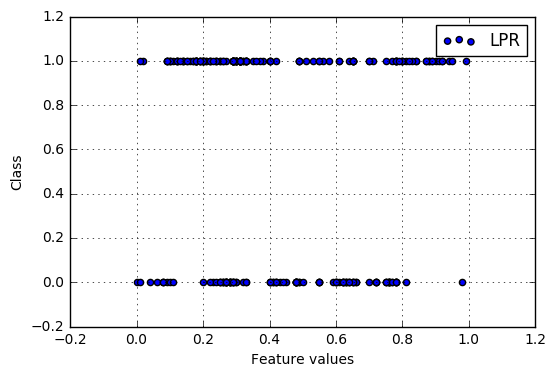

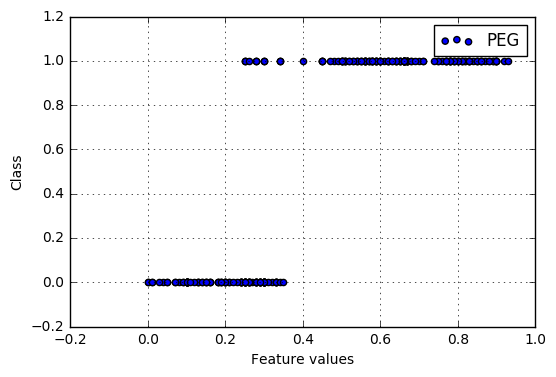

In [28]:
for i in range(5):
    plt.scatter(d[d.columns[i]], d[d.columns[5]], label=str(d.columns[i]))
    plt.grid()
    plt.legend()
    plt.xlabel('Feature values')
    plt.ylabel('Class')
    plt.show()

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Исходя из кривых значений Джини, видим, что деление выборки надо производить по признаку PEG, так как значение критерия наибольшее. Кроме того, по графикам признаков и классов видно, что выборка хорошо разделима: при малых значениях признака - один класс, при больших - другой.
Можно сказать, что для "хороших" признаков кривая должна принимать различные значения для разных порогов. Для "плохих" признаков кривая будет близка к константе.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [30]:
reload(hw3code)
mush = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                    sep=',', header=None)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
le = LabelEncoder()
mush_le = mush.apply(le.fit_transform)
mush_y = mush_le[mush_le.columns[0]]
mush_X = mush_le[mush_le.columns[1:]]

X_train, X_test, y_train, y_test = train_test_split(mush_X, mush_y, test_size=0.5)

ftr_t = ['categorical']*mush_X.shape[1]
ds = hw3code.DecisionTree(feature_types=ftr_t)
ds.fit(X_train, y_train)
preds = ds.predict(X_test)
acc = accuracy_score(y_test, preds)
print('Accuracy: ', acc)

Accuracy:  1.0


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [34]:
tic_tac = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                        sep=',', header=None)
cars = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
                     sep=',', header=None)
nursery = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
                        sep=',', header=None)

tic_tac = tic_tac.apply(le.fit_transform)
tic_tac_x = tic_tac[tic_tac.columns[:tic_tac.shape[1]-1]]
tic_tac_y = tic_tac[tic_tac.columns[-1]]
cars_y = cars[cars.columns[-1]].apply(lambda i: 1 if i=='good' or i=='vgood' else 0)
cars_x = cars[cars.columns[:cars.shape[1]-1]].apply(le.fit_transform)
nursery_y = nursery[nursery.columns[-1]].apply(lambda i: 0 if (i=='not_recom' or i=='recommend') else 1)
nursery_x = nursery[nursery.columns[:nursery.shape[1]-1]].apply(le.fit_transform)

In [35]:
results = pd.DataFrame(columns=['real', 'cat', 'one-hot', 'sklearn'], index=['mush', 'tic-tac', 'cars', 'nursery'])

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Real
ftr_t = ['real']*mush_X.shape[1]
dt = hw3code.DecisionTree(feature_types=ftr_t)
results.iloc[0]['real'] = np.mean(cross_val_score(dt, mush_X, mush_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[1]['real'] = np.mean(cross_val_score(dt, tic_tac_x, tic_tac_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[2]['real'] = np.mean(cross_val_score(dt, cars_x, cars_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[3]['real'] = np.mean(cross_val_score(dt, nursery_x, nursery_y, cv=10, scoring=make_scorer(accuracy_score)))

In [39]:
# Categorical
ftr_t = ['categorical']*mush_X.shape[1]
dt = hw3code.DecisionTree(feature_types=ftr_t)
results.iloc[0]['cat'] = np.mean(cross_val_score(dt, mush_X, mush_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[1]['cat'] = np.mean(cross_val_score(dt, tic_tac_x, tic_tac_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[2]['cat'] = np.mean(cross_val_score(dt, cars_x, cars_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[3]['cat'] = np.mean(cross_val_score(dt, nursery_x, nursery_y, cv=10, scoring=make_scorer(accuracy_score)))

In [50]:
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
mush_x_enc = pd.DataFrame(enc.fit_transform(mush_X))
tic_tac_x_enc = pd.DataFrame(enc.fit_transform(tic_tac_x))
cars_x_enc = pd.DataFrame(enc.fit_transform(cars_x))
nursery_x_enc = pd.DataFrame(enc.fit_transform(nursery_x))
ftr_t = ['real']*300
dt = hw3code.DecisionTree(feature_types=ftr_t)
results.iloc[0]['one-hot'] = np.mean(cross_val_score(dt, mush_x_enc, mush_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[1]['one-hot'] = np.mean(cross_val_score(dt, tic_tac_x_enc, tic_tac_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[2]['one-hot'] = np.mean(cross_val_score(dt, cars_x_enc, cars_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[3]['one-hot'] = np.mean(cross_val_score(dt, nursery_x_enc, nursery_y, cv=10, scoring=make_scorer(accuracy_score)))

In [40]:
# Sklearn
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
results.iloc[0]['sklearn'] = np.mean(cross_val_score(dt, mush_X, mush_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[1]['sklearn'] = np.mean(cross_val_score(dt, tic_tac_x, tic_tac_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[2]['sklearn'] = np.mean(cross_val_score(dt, cars_x, cars_y, cv=10, scoring=make_scorer(accuracy_score)))
results.iloc[3]['sklearn'] = np.mean(cross_val_score(dt, nursery_x, nursery_y, cv=10, scoring=make_scorer(accuracy_score)))

In [51]:
results

,real,cat,one-hot,sklearn
mush,0.999261,1,0.999631,0.958154
tic-tac,0.466491,0.541458,0.543575,0.751106
cars,0.942647,0.967546,0.918914,0.940972
nursery,0.999691,0.999846,0.999537,0.999691


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Можно сказать, что для разных наборов алгоритмы ранжируются одинаково с какой-то погрешностью.
На некоторых наборах (mushrooms, nursery) все алгоритмы работают очень хорошо. На некоторых (tic-tac) - заметны значительные различия в качестве работы.  

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [42]:
data = pd.read_csv('bnp.csv')[:10000]
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [43]:
data = data.fillna(value=0)
data = data.select_dtypes(exclude=['object'])
data.head()

,ID,target,v1,v2,v4,v5,v6,v7,v8,v9,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,...,0.803572,8.000000,1.989780,0.035754,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,...,0.000000,0.000000,0.000000,0.598896,0.000000,0.000000,1.957825,0,0.000000,0.000000
2,5,1,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,...,2.238806,9.333333,2.477596,0.013452,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,...,1.956521,7.018256,1.812795,0.002267,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [44]:
target = data.target
data = pd.DataFrame(data.drop('target', axis=1))
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

dt = DecisionTreeClassifier()
cs1 = cross_val_score(dt, X_train, y_train, cv=3)

bc = BaggingClassifier()
cs2 = cross_val_score(bc, X_train, y_train, cv=3)

rf = RandomForestClassifier()
cs3 = cross_val_score(rf, X_train, y_train, cv=3)

print('DT: ', np.mean(cs1), ' Bagging: ', np.mean(cs2), ' Random Forest: ', np.mean(cs3))

DT:  0.649858781393  Bagging:  0.710429926763  Random Forest:  0.717570682456


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [58]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(X_train, y_train)
acc = accuracy_score(y_test, xgb1.predict(X_test))
print('Accuracy with fixed parameters: ', acc)

Accuracy with fixed parameters:  0.749333333333


In [45]:
# Tuning n_estimators, max_depth
params1 = {
 'n_estimators': range(60, 200, 20),
 'max_depth': range(3,10,2)
}
estimator = XGBClassifier(learning_rate=0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch1 = GridSearchCV(estimator, param_grid = params1, scoring='accuracy', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76172, std: 0.00608, params: {'n_estimators': 60, 'max_depth': 3},
  mean: 0.76086, std: 0.00584, params: {'n_estimators': 80, 'max_depth': 3},
  mean: 0.76272, std: 0.00826, params: {'n_estimators': 100, 'max_depth': 3},
  mean: 0.76172, std: 0.00685, params: {'n_estimators': 120, 'max_depth': 3},
  mean: 0.76100, std: 0.00647, params: {'n_estimators': 140, 'max_depth': 3},
  mean: 0.76014, std: 0.00787, params: {'n_estimators': 160, 'max_depth': 3},
  mean: 0.76057, std: 0.00674, params: {'n_estimators': 180, 'max_depth': 3},
  mean: 0.76086, std: 0.00679, params: {'n_estimators': 60, 'max_depth': 5},
  mean: 0.75929, std: 0.00773, params: {'n_estimators': 80, 'max_depth': 5},
  mean: 0.75829, std: 0.00743, params: {'n_estimators': 100, 'max_depth': 5},
  mean: 0.75714, std: 0.00604, params: {'n_estimators': 120, 'max_depth': 5},
  mean: 0.75600, std: 0.00704, params: {'n_estimators': 140, 'max_depth': 5},
  mean: 0.75586, std: 0.00513, params: {'n_estimators': 160, 'max_de

In [46]:
n_est_best = gsearch1.best_params_['n_estimators']
md_best = gsearch1.best_params_['max_depth']

In [54]:
# After tuning
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb2.fit(X_train, y_train)
acc = accuracy_score(y_test, xgb2.predict(X_test))
print('Accuracy with fixed parameters: ', acc)

Accuracy with fixed parameters:  0.770333333333


__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

(・・ ) ?